In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
data_path = './data'
idlist_path = '/player_idlist.csv'
players_path = '/players'
season = '/2018-19'

In [3]:
idlist = pd.read_csv(data_path + season + idlist_path)

In [4]:
#create players
players = pd.DataFrame()
for index, row in idlist.iterrows():
    first_name = row['first_name']
    second_name = row['second_name']
    player_id = row['id']
    player_path = '/' +first_name + '_' + second_name + '_' + str(player_id)
    
    player = pd.read_csv(data_path + season + players_path + player_path + '/gw.csv')
    player['gw'] = np.arange(len(player)) + 1
    player['player_id'] = player_id
    players = pd.concat([players, player], axis=0)

In [5]:
#load teams data
teams = pd.read_csv(data_path + season + '/teams_raw.csv')
teams.rename(columns={'id': 'team_id'}, inplace=True)

#load element_types data
element_types = pd.read_csv(data_path + season + '/element_types_raw.csv')
element_types.drop(columns=['plural_name', 'plural_name_short'],inplace=True)
element_types.rename(columns={'id':'element_type_id', 'singular_name': 'position_name', 'singular_name_short' : 'position_short'}, inplace=True)

#load player_cleaned data
cleaned_players = pd.read_csv(data_path + season + '/cleaned_players.csv')
cleaned_players.rename(columns={'id':'player_id'}, inplace=True)

In [6]:
#prepare players data
players = pd.merge(players, cleaned_players.loc[:,['player_id', 'first_name', 'second_name', 'team', 'element_type']], on='player_id')

#merge team name
players = pd.merge(players, teams.loc[:, ['team_id', 'name']], left_on='team', right_on='team_id')
players.drop(columns=['team_id', 'team'], inplace=True)
players.rename(columns={'name':'team'}, inplace=True)

#merge element type 
players = pd.merge(players, element_types, left_on='element_type', right_on='element_type_id')
players.drop(columns=['element_type', 'element_type_id'], inplace=True)
players.rename(columns={'position_name':'position'}, inplace=True)

#rename total_points to points
players.rename(columns={'total_points':'points'}, inplace=True)

In [7]:
#swap columns
players = pd.concat([players.iloc[:, -7:], players.iloc[:, :-7]], axis=1)

#add features
players['goal_consistency'] = players['goals_scored'] > 0
players['assist_consistency'] = players['assists'] > 0

players['goals_and_assists'] = players['goals_scored'] + players['assists']
players['goal_or_assist_consistency'] = players['goal_consistency'] | players['assist_consistency']

In [8]:
def stat_by_was_home(player_id, stat, agg):
    player = players.loc[players.player_id == player_id, :]
    home = player.loc[player.was_home == True, :]
    away = player.loc[player.was_home == False, :]
    return home[stat].aggregate(agg), away[stat].aggregate(agg)

In [9]:
def player_stat_in_last_n_gw(player_id, stat, aggregate, n_gw):
    player = players.loc[players.player_id == player_id, :]
    if(player.shape[0] > n_gw):
        if(n_gw == 1):
            return player[stat].shift(1)
        else:
            return player[stat].shift().rolling(min_periods=n_gw, window=n_gw).aggregate(aggregate)
    else:
        return pd.Series(np.full(player.shape[0], np.nan))


In [10]:
def plot_last_3_gws_stat_affects_has_goals(player_id, stat, agg):
    player = players.loc[players.player_id == player_id, :]
    player['has_goal'] = player['goals_scored'] > 0
    player[stat + '_1_gw_before'] = player_stat_in_last_n_gw(player_id, stat, agg, 1)
    player[stat + '_2_gw_before'] = player_stat_in_last_n_gw(player_id, stat, agg, 2)
    player[stat + '_3_gw_before'] = player_stat_in_last_n_gw(player_id, stat, agg, 3)

    has_goal = player.loc[player.has_goal, :]
    no_goal = player.loc[~(player.has_goal), :]

    plt.figure(figsize=(20, 5))
    
    for i in range(1, 4):
        #plot last n GWs stat
        x1 = has_goal[f"{stat}_{i}_gw_before"].dropna()
        x2 = no_goal[f"{stat}_{i}_gw_before"].dropna()

        lower = player[f"{stat}_{i}_gw_before"].min()
        upper = player[f"{stat}_{i}_gw_before"].max()

        bins = np.arange(lower, upper + 2, 1)

        plt.subplot(1, 3, i)
        plt.hist([x1, x2], label=['has_goals', 'no_goal'], bins=bins, histtype='bar', align='left')
        plt.title(f"{stat} last {i} GWs distributtion")
        plt.xlabel(f"{stat} last {i} GWs")
        plt.ylabel('Number of GWs')
        plt.xticks(bins)
        plt.legend()
    plt.show()
    

def plot_last_3_gws_stat_affects_more_than_10_points(player_id, stat, agg):
    player = players.loc[players.player_id == player_id, :]
    player['more_than_10_points'] = player['points'] >= 8
    player[stat + '_1_gw_before'] = player_stat_in_last_n_gw(player_id, stat, agg, 1)
    player[stat + '_2_gw_before'] = player_stat_in_last_n_gw(player_id, stat, agg, 2)
    player[stat + '_3_gw_before'] = player_stat_in_last_n_gw(player_id, stat, agg, 3)

    has_effect = player.loc[player.more_than_10_points, :]
    no_effect = player.loc[~(player.more_than_10_points), :]

    plt.figure(figsize=(20, 5))
    
    for i in range(1, 4):
        #plot last n GWs stat
        x1 = has_effect[f"{stat}_{i}_gw_before"].dropna()
        x2 = no_effect[f"{stat}_{i}_gw_before"].dropna()

        lower = player[f"{stat}_{i}_gw_before"].min()
        upper = player[f"{stat}_{i}_gw_before"].max()

        bins = np.arange(lower, upper + 2, 1)

        plt.subplot(1, 3, i)
        plt.hist([x1, x2], label=['more_than_10_points', 'no_more_than_10_points'], bins=bins, histtype='bar', align='left')
        plt.title(f"{stat} last {i} GWs distributtion")
        plt.xlabel(f"{stat} last {i} GWs")
        plt.ylabel('Number of GWs')
        plt.xticks(bins)
        plt.legend()
    plt.show()

In [11]:
def plot_stat_by_was_home(player_id, stat, agg):
    player = players.loc[players.player_id == player_id, :]
    grouped = player.groupby('was_home', as_index=False)[stat].agg(agg)
    home_stat = grouped.loc[grouped.was_home, stat]
    away_stat = grouped.loc[~grouped.was_home, stat]
    
    ind = np.arange(1) 
    width = 0.5
    plt.figure(figsize=(8, 7))
    plt.bar(ind, home_stat.values, width=width, align='center')
    plt.bar(ind + width, away_stat.values, width=width, align='center')
    plt.title(stat + ' by was home')
    plt.ylabel('Number of ' + stat)
    plt.xticks([0, 0.5], ['home', 'away'])
    plt.show()

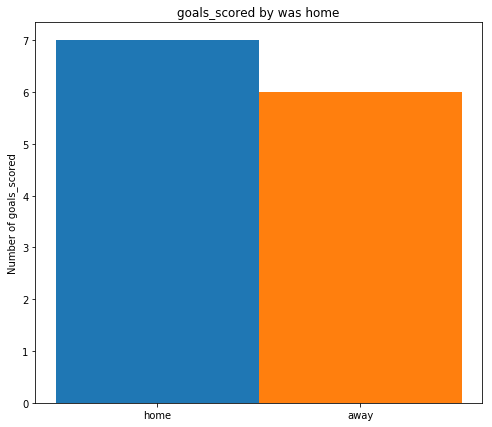

In [12]:
plot_stat_by_was_home(253, 'goals_scored', np.sum)

## Is total historical goals affect current goal consistency?

Kane


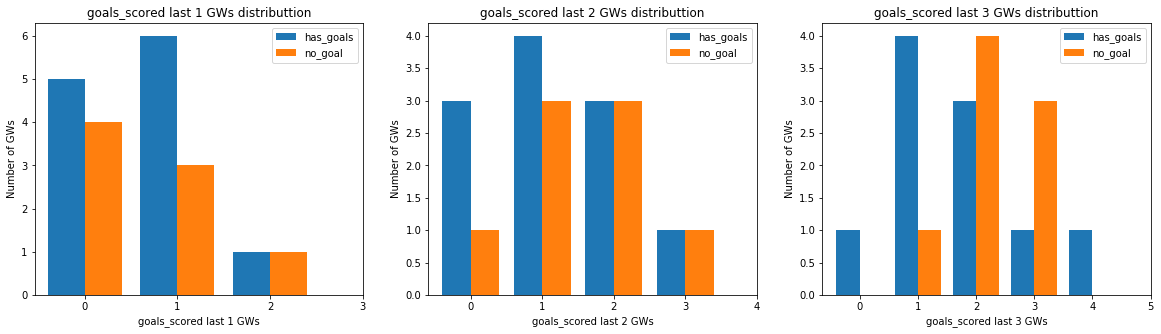

Aubameyang


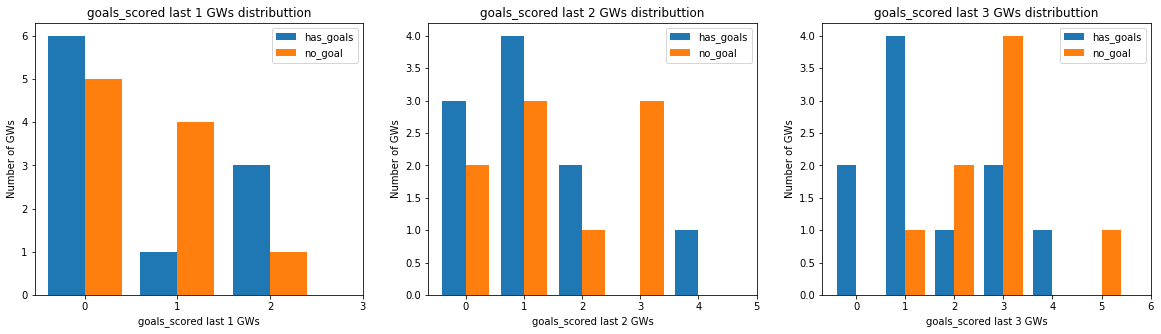

Salah


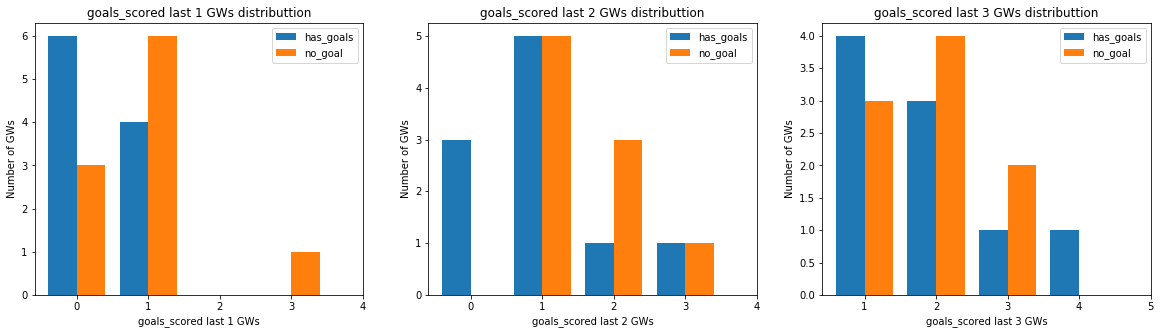

Hazard


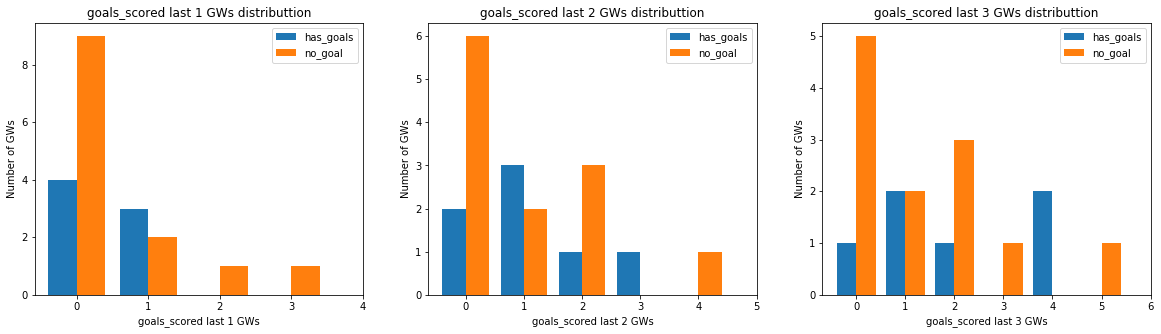

Agüero


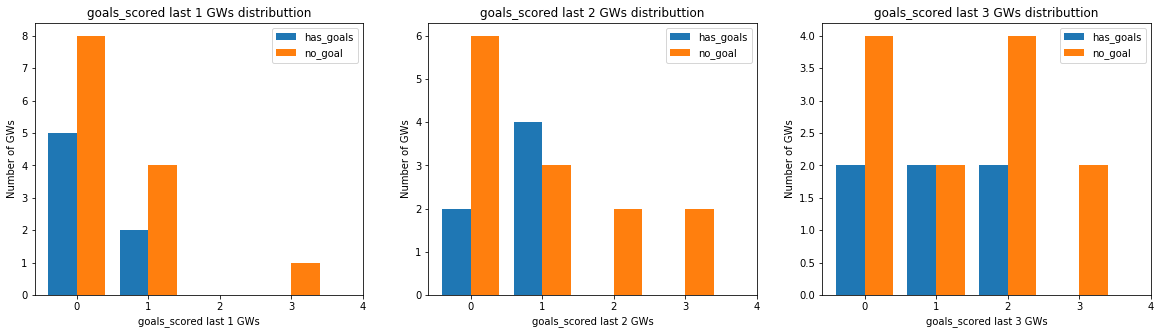

Sterling


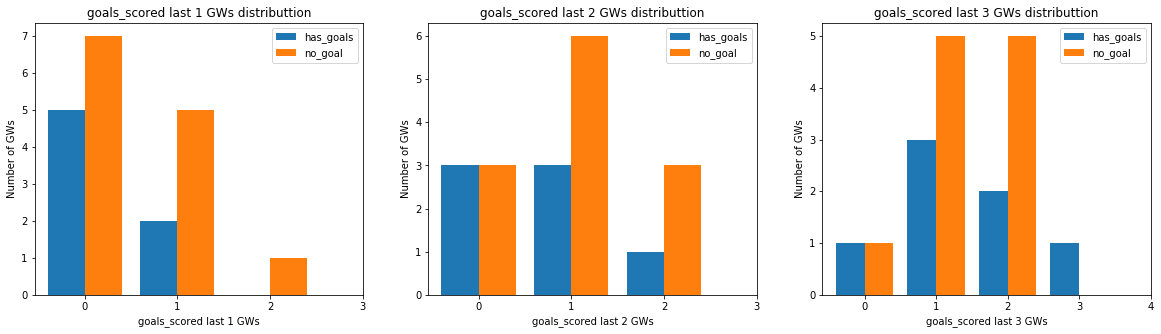

de Andrade


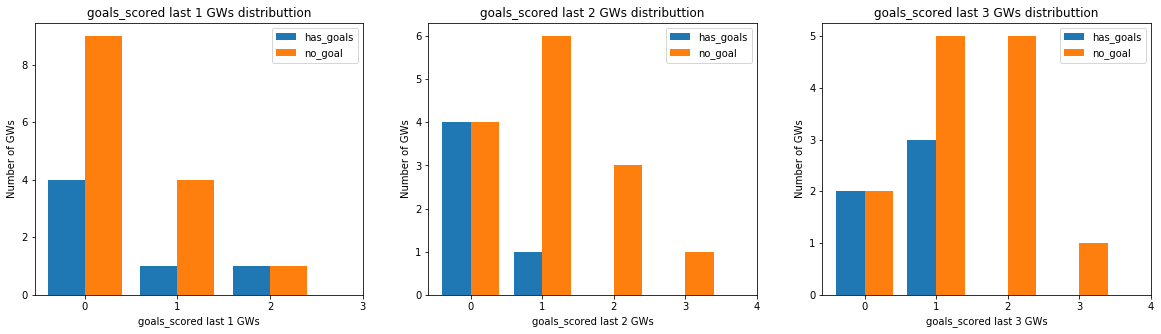

Martial


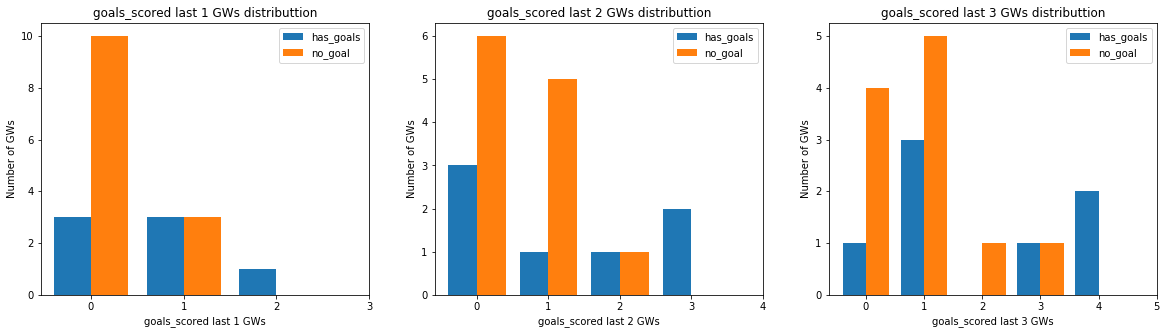

Pereira Gomes


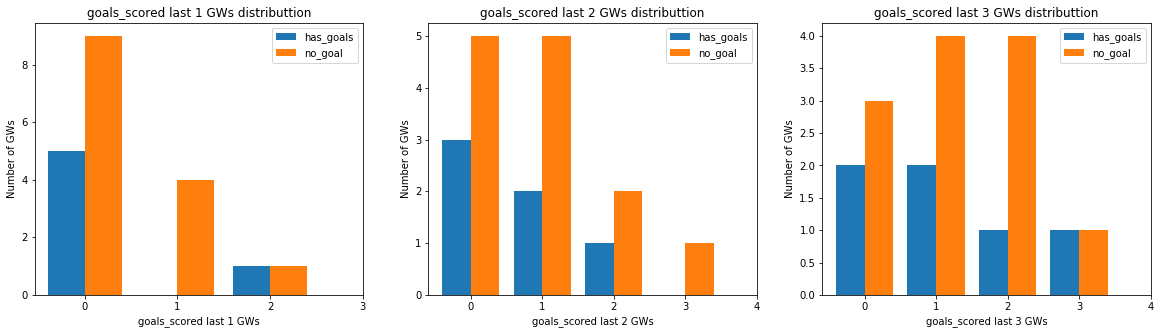

Wilson


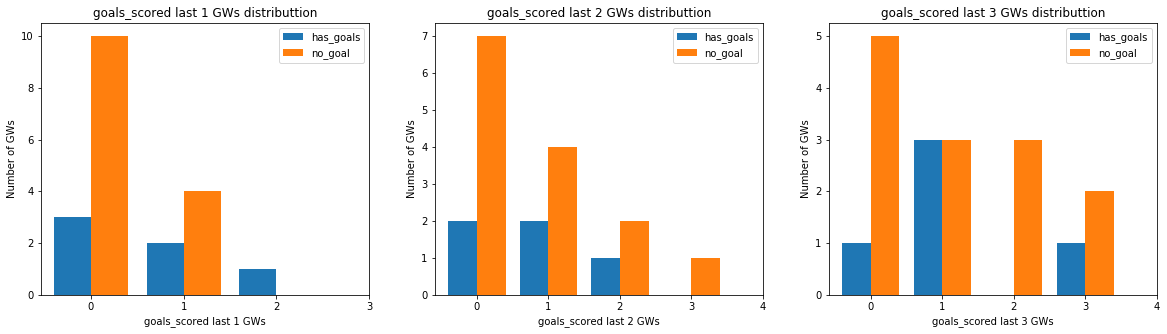

In [13]:
df = players.copy()
total_goals_grouped_by_player_id = df.groupby(df.player_id, as_index=False)['goals_scored'].sum()
total_goals_grouped_by_player_id = pd.merge(cleaned_players.loc[:, ['player_id', 'second_name']], total_goals_grouped_by_player_id, on='player_id')

top_scorers = total_goals_grouped_by_player_id.sort_values('goals_scored', ascending=False)[:10]

for index, row in top_scorers.iterrows():
    print(row['second_name'])
    plot_last_3_gws_stat_affects_has_goals(row['player_id'], 'goals_scored', np.sum)

## Is total historical goals and assists affect current goal consistency?

Kane


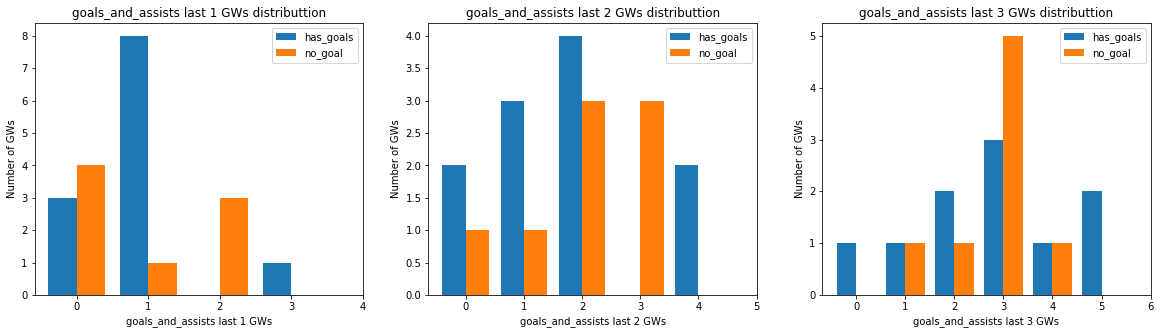

Aubameyang


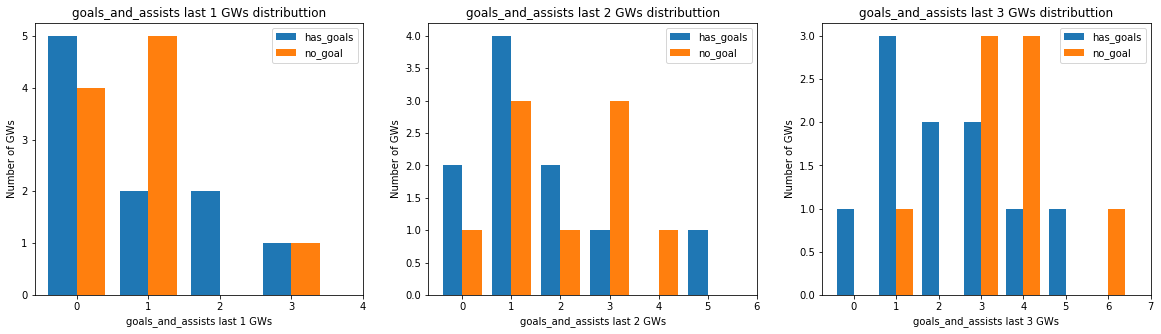

Salah


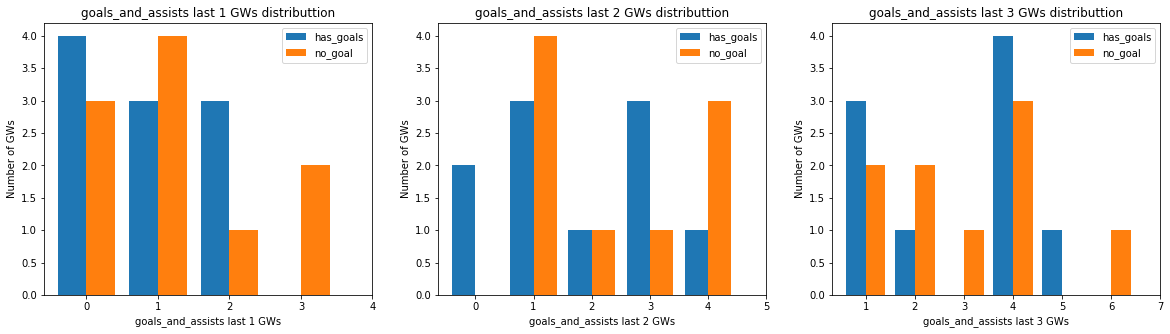

Hazard


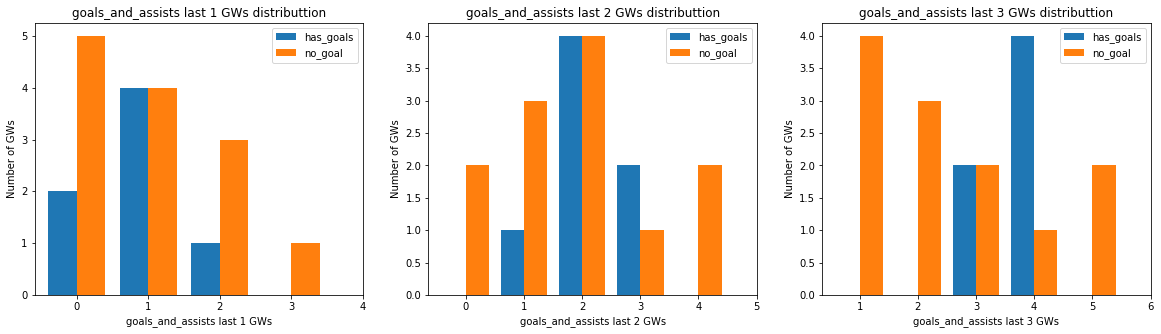

Agüero


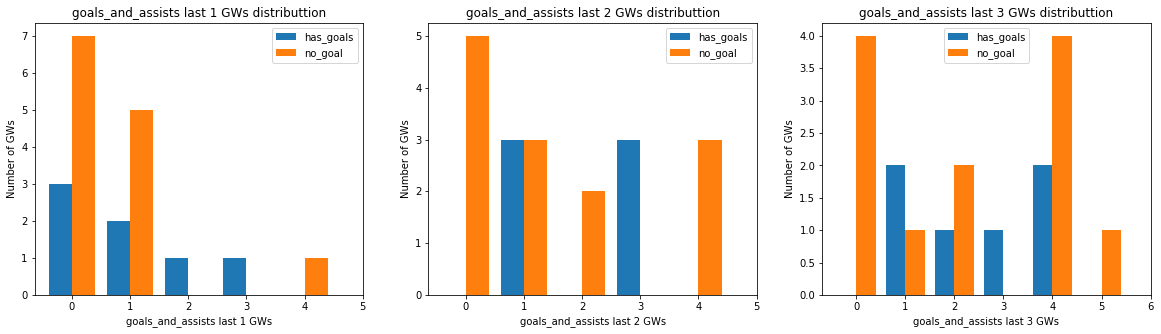

Sterling


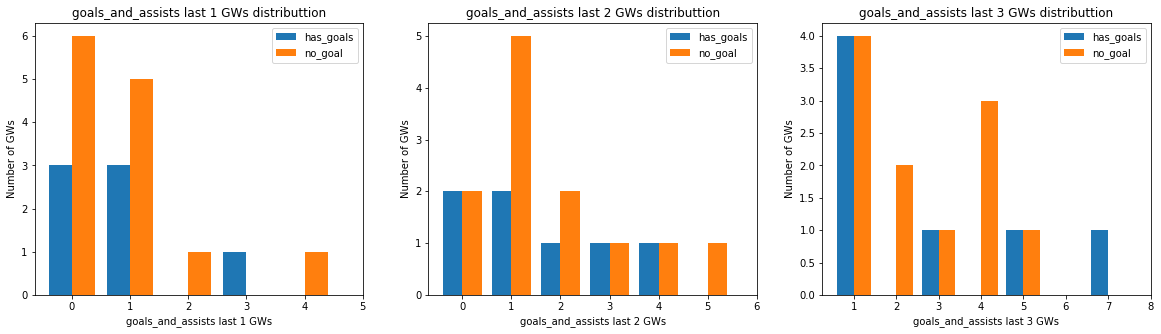

de Andrade


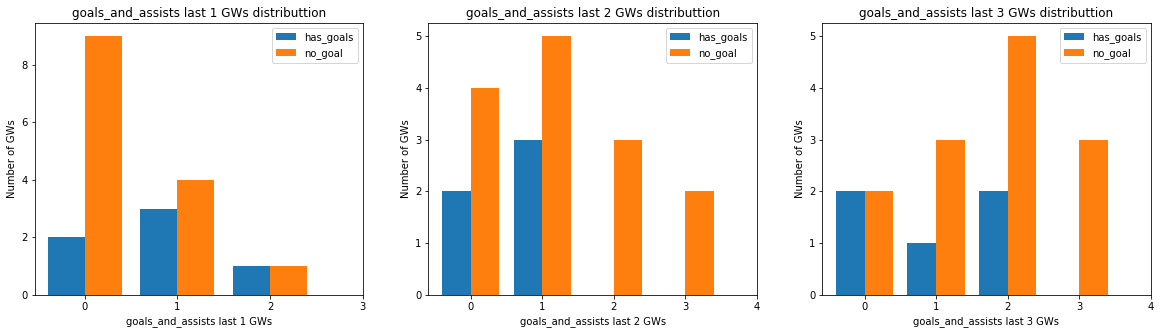

Martial


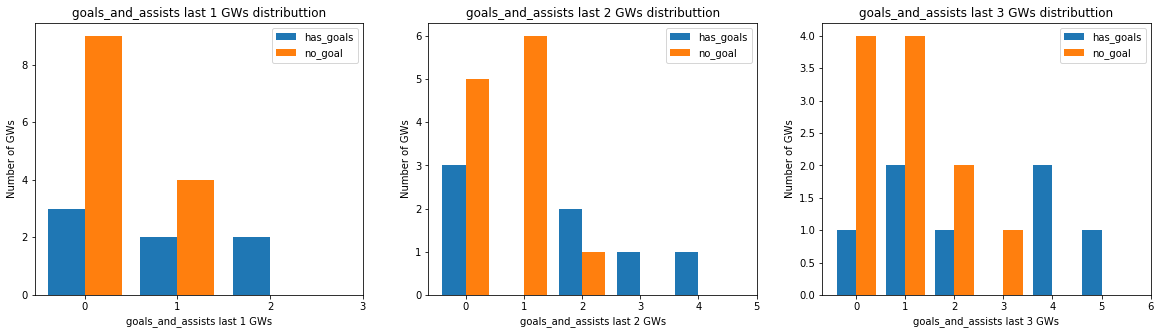

Pereira Gomes


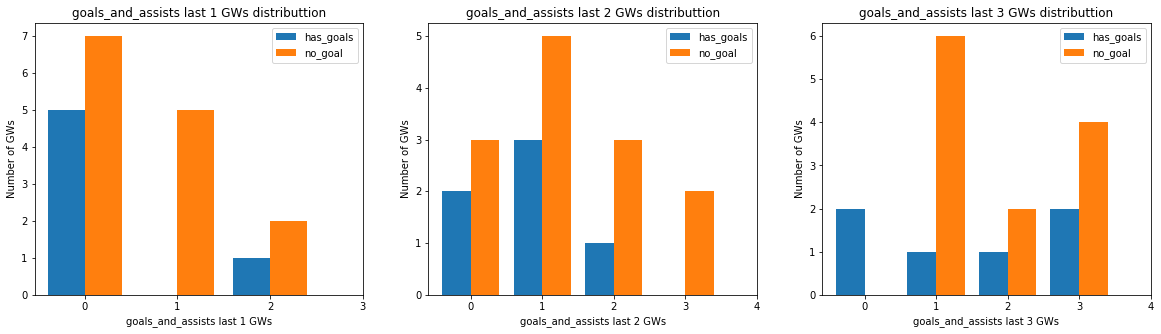

Wilson


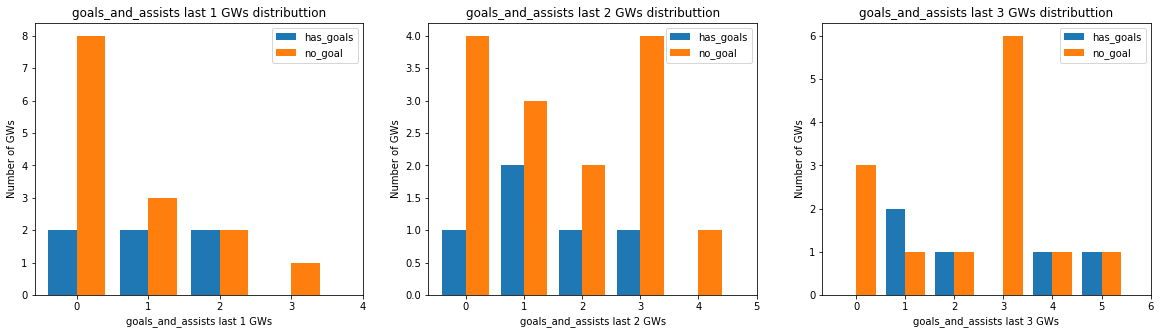

In [14]:
for index, row in top_scorers.iterrows():
    print(row['second_name'])
    plot_last_3_gws_stat_affects_has_goals(row['player_id'], 'goals_and_assists', np.sum)
    

## Is historical goals consistency affects current goal consistency?

Kane


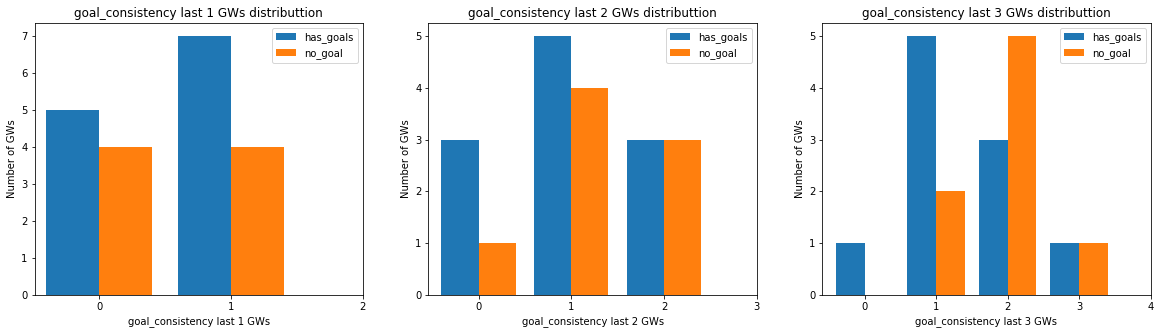

Aubameyang


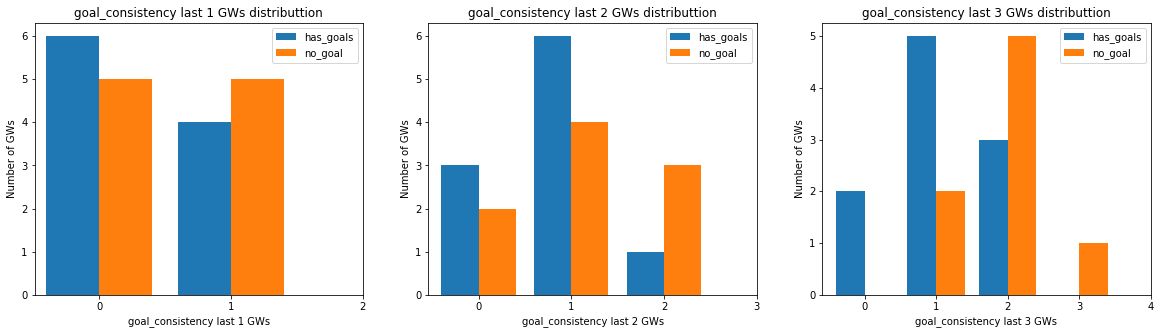

Salah


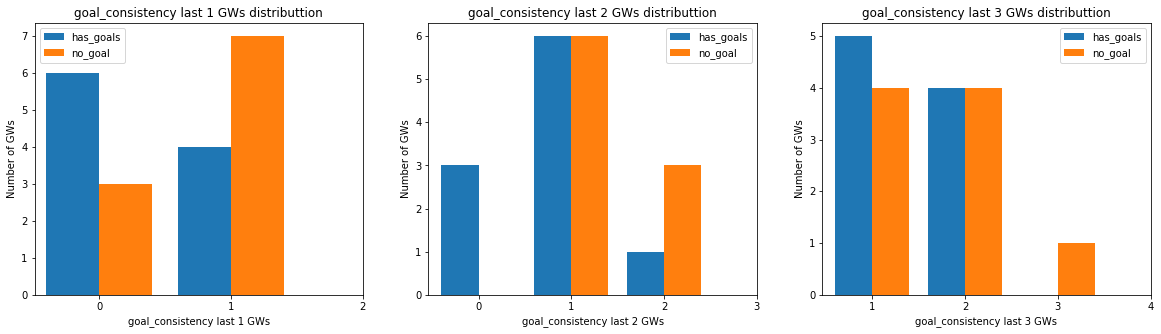

Hazard


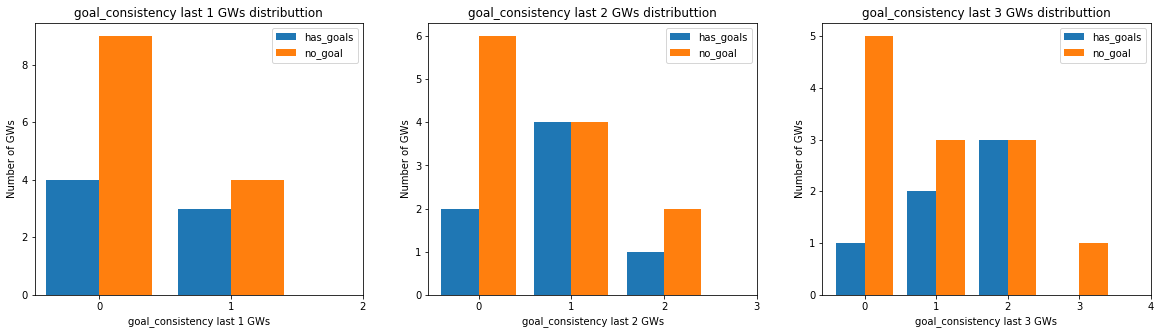

Agüero


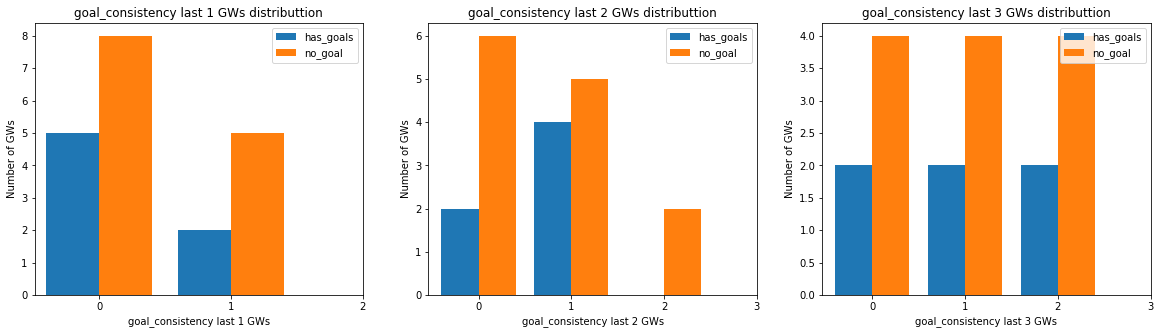

Sterling


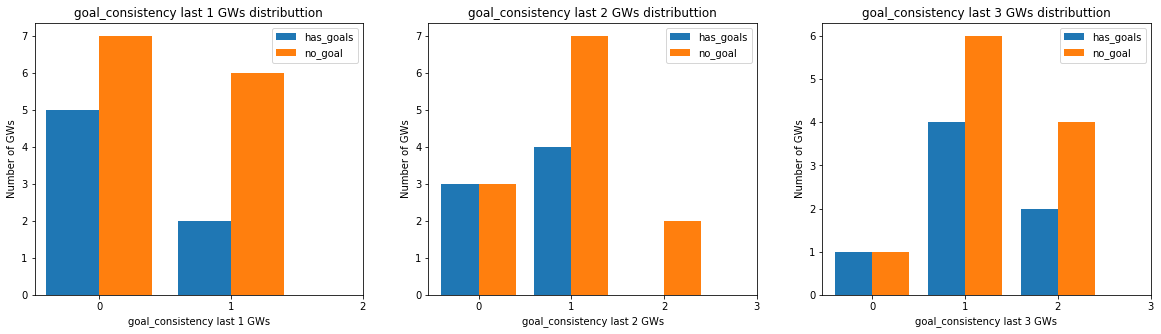

de Andrade


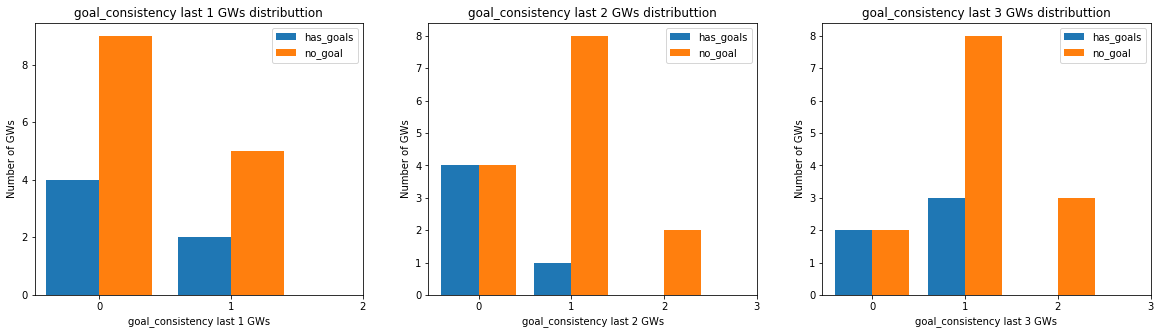

Martial


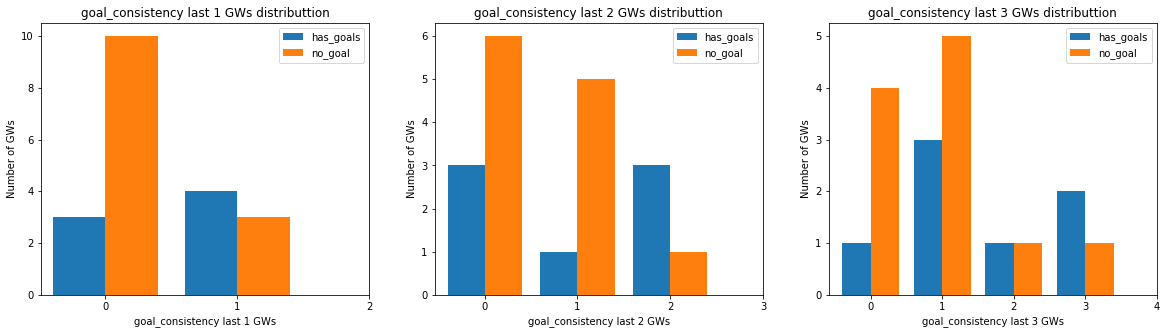

Pereira Gomes


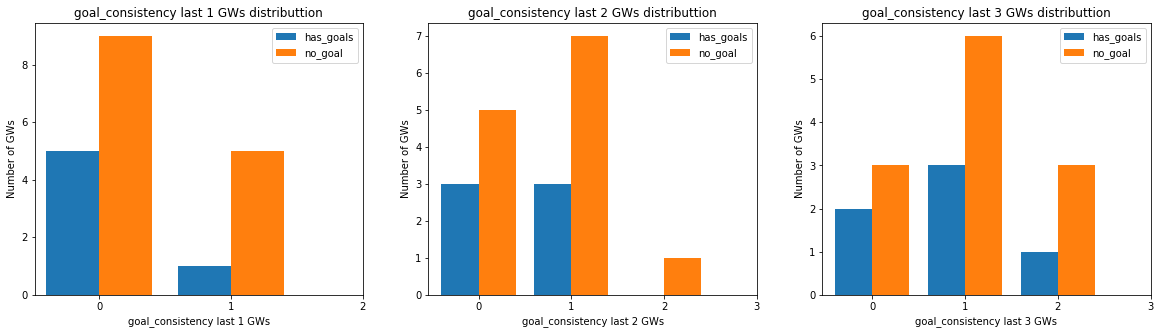

Wilson


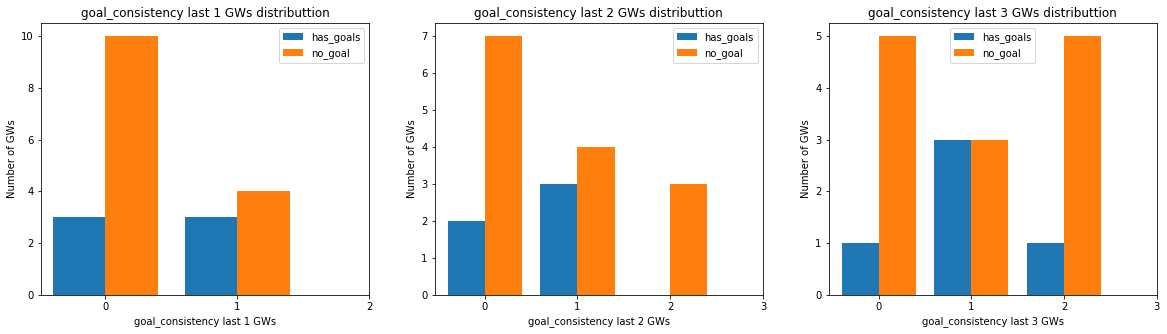

In [15]:
for index, row in top_scorers.iterrows():
    print(row['second_name'])
    plot_last_3_gws_stat_affects_has_goals(row['player_id'], 'goal_consistency', np.sum)

## Is goal or assists consistency affects current goal consistency?

Kane


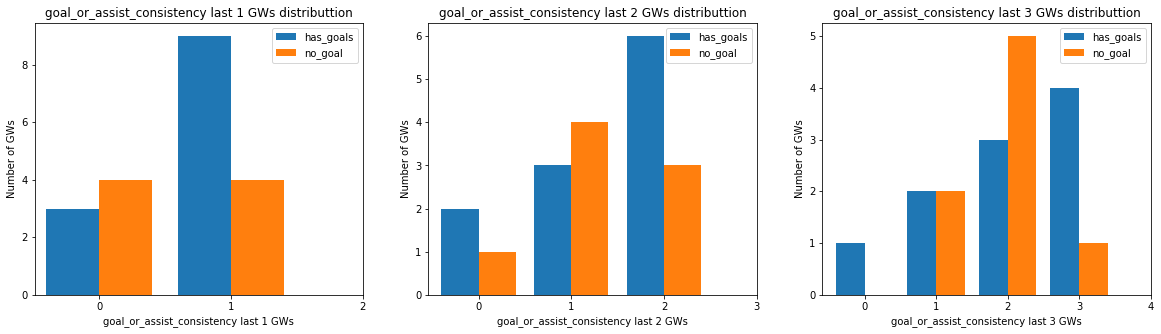

Aubameyang


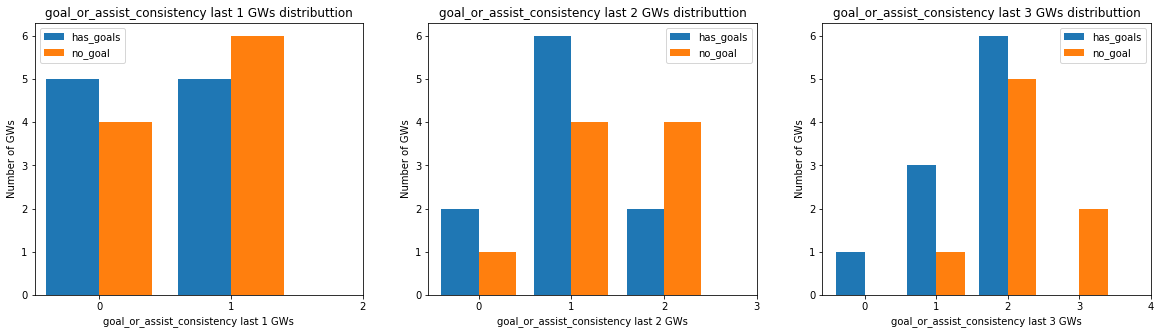

Salah


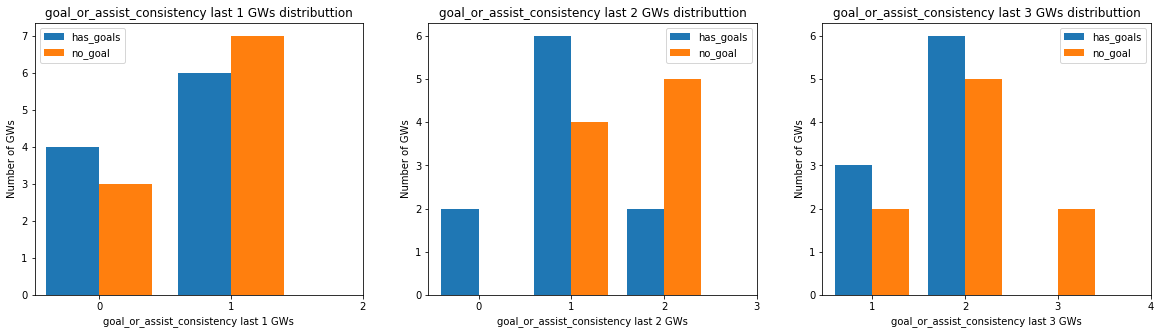

Hazard


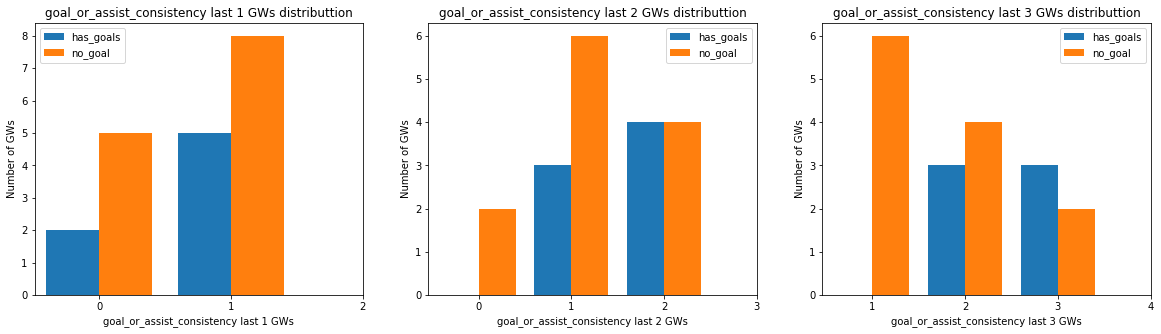

Agüero


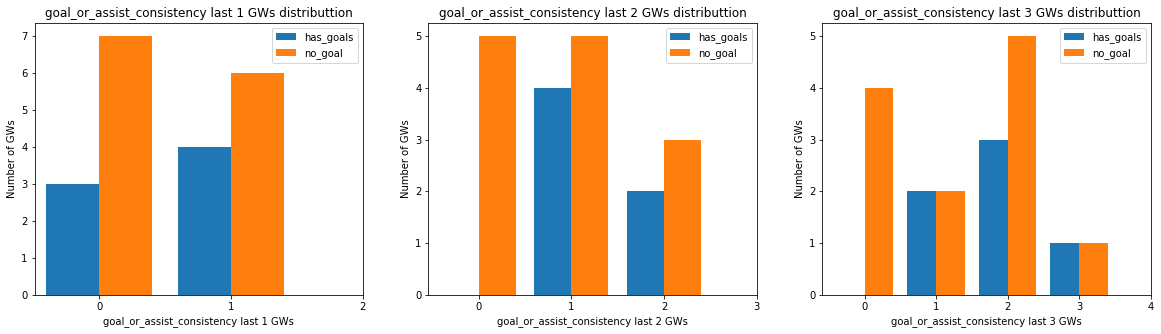

Sterling


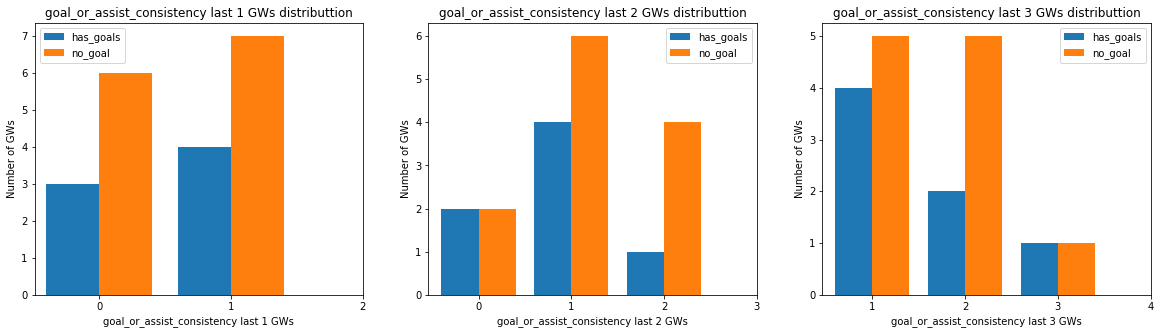

de Andrade


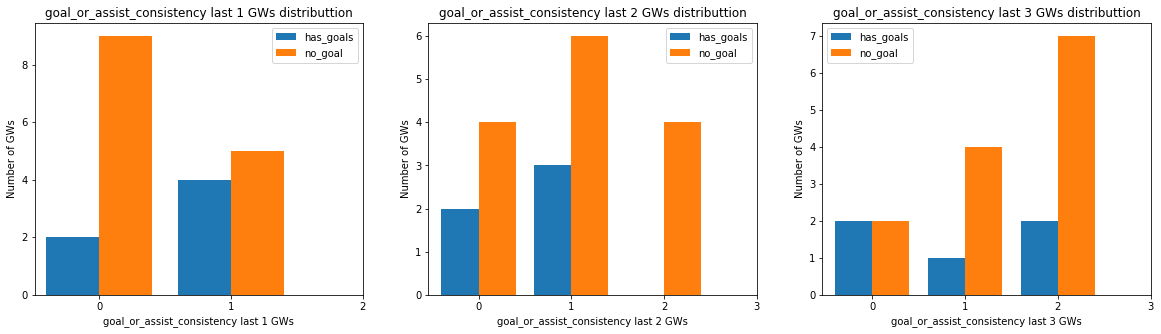

Martial


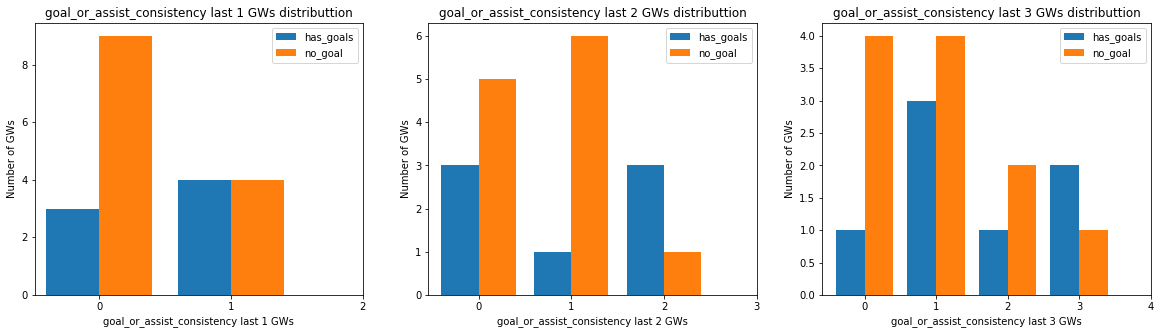

Pereira Gomes


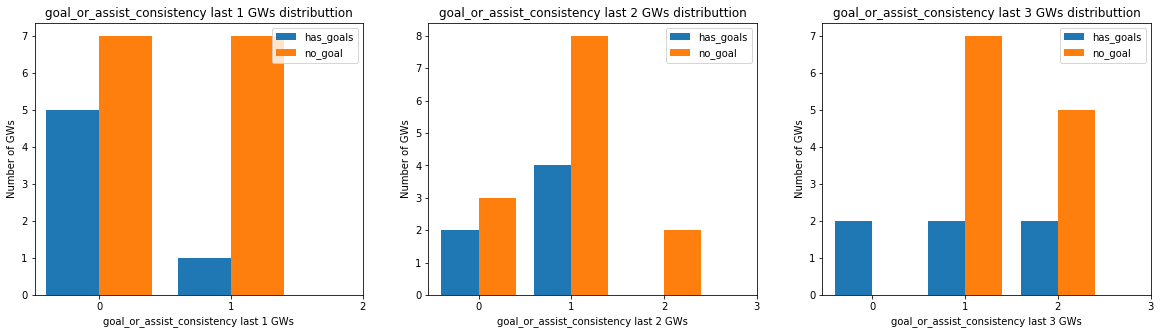

Wilson


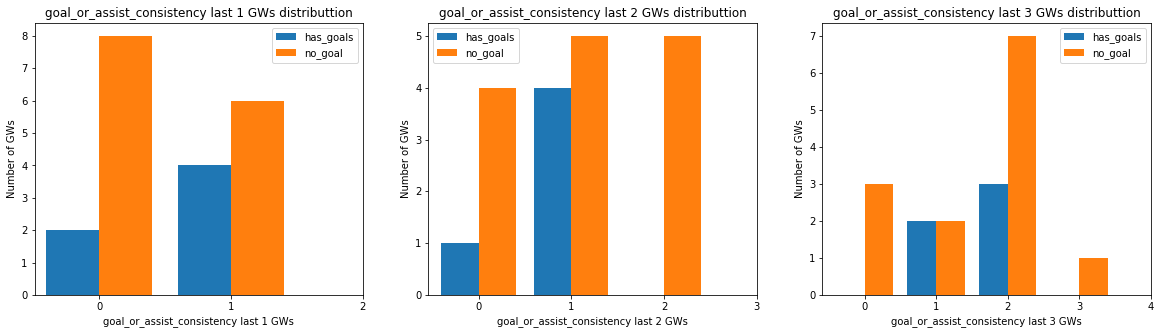

In [16]:
for index, row in top_scorers.iterrows():
    print(row['second_name'])
    plot_last_3_gws_stat_affects_has_goals(row['player_id'], 'goal_or_assist_consistency', np.sum)

In [17]:
salah = players.loc[players.player_id == 253, :]

In [18]:
def other_players_stat_for_gw(player_id, gw, stat, agg):
    team = players.loc[players.player_id == player_id, ['team']].iloc[0].values[0]
    is_other = players['player_id'] != player_id
    is_same_team = players['team'] == team
    is_same_gw = players['gw'] == gw
    is_played = players['minutes'] > 50
    other = players.loc[is_other & is_same_team & is_same_gw & is_played, :]
    return other[stat].aggregate(agg)

def other_players_stat_for_all_gws(player_id, stat, agg):
    player = players.loc[players.player_id == player_id, :]
    gws = player['gw']
    results = pd.Series(list(map(lambda x: other_players_stat_for_gw(player_id, x, stat, agg), gws)))
    return results

def opponent_players_stat_for_gw(player_id, gw, stat, agg):
    opponent_team_id = players.loc[(players.player_id == player_id) & (players.gw == gw), ['opponent_team']].iloc[0].values[0]
    opponent_team = teams.loc[teams.team_id == opponent_team_id, 'name'].values[0]
    
    opponent_players = players.loc[(players.gw == gw) & (players.team == opponent_team) & (players.minutes > 50), :]
    return opponent_players[stat].aggregate(agg)

def opponent_players_stat_for_all_gws(player_id, stat, agg):
    player = players.loc[players.player_id == player_id, :]
    gws = player['gw']
    results = pd.Series(list(map(lambda x: opponent_players_stat_for_gw(player_id, x, stat, agg), gws)))
    return results


In [47]:
player_id = 23
player = players.loc[players.player_id == player_id, :]
player['has_goals'] = player.goal_consistency.astype(int)

In [48]:
player['total_goals_1_gw_before'] = player_stat_in_last_n_gw(player_id=player_id, stat='goals_scored', aggregate=np.sum, n_gw=1)
player['total_goals_2_gw_before'] = player_stat_in_last_n_gw(player_id=player_id, stat='goals_scored', aggregate=np.sum, n_gw=2)
player['total_goals_3_gw_before'] = player_stat_in_last_n_gw(player_id=player_id, stat='goals_scored', aggregate=np.sum, n_gw=3)

player['goals_consistency_1_gw_before'] = player_stat_in_last_n_gw(player_id=player_id, stat='goal_consistency', aggregate=np.sum, n_gw=1)
player['goals_consistency_2_gw_before'] = player_stat_in_last_n_gw(player_id=player_id, stat='goal_consistency', aggregate=np.sum, n_gw=2)
player['goals_consistency_3_gw_before'] = player_stat_in_last_n_gw(player_id=player_id, stat='goal_consistency', aggregate=np.sum, n_gw=3)

player['total_goals_and_assists_1_gw_before'] = player_stat_in_last_n_gw(player_id=player_id, stat='goals_and_assists', aggregate=np.sum, n_gw=1)
player['total_goals_and_assists_2_gw_before'] = player_stat_in_last_n_gw(player_id=player_id, stat='goals_and_assists', aggregate=np.sum, n_gw=2)
player['total_goals_and_assists_3_gw_before'] = player_stat_in_last_n_gw(player_id=player_id, stat='goals_and_assists', aggregate=np.sum, n_gw=3)

player['goals_or_assists_consistency_1_gw_before'] = player_stat_in_last_n_gw(player_id=player_id, stat='goal_or_assist_consistency', aggregate=np.sum, n_gw=1)
player['goals_or_assists_consistency_2_gw_before'] = player_stat_in_last_n_gw(player_id=player_id, stat='goal_or_assist_consistency', aggregate=np.sum, n_gw=2)
player['goals_or_assists_consistency_3_gw_before'] = player_stat_in_last_n_gw(player_id=player_id, stat='goal_or_assist_consistency', aggregate=np.sum, n_gw=3)



In [81]:
attrs = ['total_goals_1_gw_before', 'total_goals_2_gw_before', 'total_goals_3_gw_before']
target = ['has_goals']
player[attrs + target].fillna(0)

,total_goals_1_gw_before,total_goals_2_gw_before,total_goals_3_gw_before,has_goals
9939,0.0,0.0,0.0,0
9940,0.0,0.0,0.0,0
9941,0.0,0.0,0.0,0
9942,0.0,0.0,0.0,1
9943,1.0,1.0,1.0,0
9944,0.0,1.0,1.0,1
9945,1.0,1.0,2.0,0
9946,0.0,1.0,1.0,1
9947,2.0,2.0,3.0,1
9948,2.0,4.0,4.0,1


In [82]:
test_instance = player.iloc[-1:, :]
test_instance

,gw,player_id,first_name,second_name,team,position,position_short,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,fixture,fouls,goals_conceded,goals_scored,ict_index,id,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,opponent_team,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,goal_consistency,assist_consistency,goals_and_assists,goal_or_assist_consistency,has_goals,total_goals_1_gw_before,total_goals_2_gw_before,total_goals_3_gw_before,goals_consistency_1_gw_before,goals_consistency_2_gw_before,goals_consistency_3_gw_before,total_goals_and_assists_1_gw_before,total_goals_and_assists_2_gw_before,total_goals_and_assists_3_gw_before,goals_or_assists_consistency_1_gw_before,goals_or_assists_consistency_2_gw_before,goals_or_assists_consistency_3_gw_before
9959,21,23,Pierre-Emerick,Aubameyang,Arsenal,Forward,FWD,1,37,0,4,0,27,0,2,23,27.0,2,0,23,0,0,201,1,1,1,15.1,10984,40.4,2,2019-01-01T15:00:00Z,01 Jan 15:00,0,0,90,1,0,9,0,0,0,0,1,0,21,0,2162900,2,1,3,1.0,4.0,84.0,9,29678,125626,95948,114,True,0,0,True,True,2,True,1,0.0,1.0,3.0,False,1.0,2.0,0.0,1.0,3.0,False,1.0,2.0


In [83]:
def stat_last_n_gw(player_id, stat, agg, n_gw):
    player = players.loc[players.player_id == player_id, :]
    last_n_row = player.iloc[-n_gw:, :]
    return last_n_row[stat].aggregate(agg)

In [84]:
stat_n_gw_before(23, 'goals_scored', np.sum, 3)

2